## Libraries

In [1]:
### Importing required libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from sklearn.externals import joblib
# %matplotlib qt

# 1. Chess Board Images

## 1.1 Camera Caliberation

In [2]:
## draw and find chess corners for camera caliberation
def camera_caliberation(file,nx,ny):
    img = cv2.imread(file)
    # plt.imshow(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,corner = cv2.findChessboardCorners(gray,(nx,ny),None) ## identify the inner square corners
    # ret
    if ret :
        cv2.drawChessboardCorners(img,(nx,ny),corner,ret)  ## draw the identified corners on orignal image
        return {'img':img,'corner':corner}
    # plt.imshow(img)
    else : return {'img':img,'corner':'NA'}

In [3]:
def obj_img_points(calib_images,nx,ny):
    objpoints = [] ## store the mesh grid points for images in which corners are identified
    imgpoints = [] ## store the corners of images identified 

    objp = np.zeros((ny*nx,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for i in calib_images:
        temp_dict = camera_caliberation(i,nx,ny)
        if temp_dict['corner']!='NA':
            imgpoints.append(temp_dict['corner'])
            objpoints.append(objp)
    return imgpoints,objpoints


In [4]:
def caliberation_coeff(img,objpoints,imgpoints):
    ## calculate the coeff for caliberation
    retval, cameraMatrix, distCoeffs, rvecs, tvecs=cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
    return cameraMatrix,distCoeffs

## 1.2 Perspective Transformation for Chess Board Images

In [5]:
def perspective_transform(file,cameraMatrix,distCoeffs,nx,ny):
    img = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB) ## converting from BGR to RGB as cv2 read image in RGB format
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) ## RGB to gray 
    ret,corner = cv2.findChessboardCorners(gray,(nx,ny),None) ## get the corners 
    if ret:
        cv2.drawChessboardCorners(img,(nx,ny),corner,ret) ## draw the corners
        undist = cv2.undistort(img,cameraMatrix,distCoeffs,None,cameraMatrix) ## undistrot the image using coeff

        src = np.float32([corner[0],corner[nx-1],corner[-1],corner[-nx]]) ## defining source point as corners identified
        img_shape = img.shape[1::-1]
        offset = 100
        dst  = np.float32([[offset,offset],[img_shape[0]-offset,offset],[img_shape[0]-offset,img_shape[1]-offset]
                           ,[offset,img_shape[1]-offset]]) ## defining destination point of identified corners on new view
        M = cv2.getPerspectiveTransform(src,dst) ## getting tranformation matrix
        warped = cv2.warpPerspective(undist,M,img_shape) ## applying transformation

        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(undist)
        plt.subplot(1,2,2)
        plt.imshow(warped)

        return warped,M
    else :
        return img,'x'

# 2.  Road Images

## 2.1 Undistortion , Color Threshold and Gradient Threshold

In [6]:
def undist_color_gradient(image,cameraMatrix,distCoeffs,sx_thresh = (20,100),s_thresh = (150,255),l_thresh = (200,255)):
    undist = cv2.undistort(image,cameraMatrix,distCoeffs,None,cameraMatrix)
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## convert to HLS space color thresholding
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    img_g = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY) ## convert to Gray space for gradient thresholding

    sobelx = cv2.Sobel(img_g,cv2.CV_64F,1,0) ## Gradient calculation in x direction as lanes are vertical
    absobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*absobelx/np.max(absobelx))

    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx>=sx_thresh[0]) & (scaled_sobelx<=sx_thresh[1])] = 1 ## gradient threshold application to remove noisly edges


    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel>=s_thresh[0]) & (s_channel <= s_thresh[1])] =1 ## color thresholding to remove noisy edges

    lbinary = np.zeros_like(l_channel)
    lbinary[(l_channel>=l_thresh[0]) & (l_channel <= l_thresh[1])] =1 ## color thresholding to remove noisy edges



    color_binary = np.dstack((np.zeros_like(sxbinary),lbinary,sbinary))*255 ## image to project the above changes
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (sxbinary==1) |   (sbinary==1) | (lbinary==1)]=1 ## filter for gradient and color threshold

    return combined_binary


## 2.2 Perspective Transformation

In [7]:
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def perspective_change(image_ls):
    
    orig_pts_m = np.array([[(170,700),(600,450),(740,450),(1250,700)]])
    image_ls = region_of_interest(image_ls,orig_pts_m)

    img_shape = image_ls.shape[1::-1] 
    orig_pts = [[170,700],[600,450],[740,450],[1250,700]]
    dest_o = [[0+300,700],[0+300,0],[img_shape[0]-300,0],[img_shape[0]-300,700]]
#     dest_o = [[0+300,700],[0+300,0],[img_shape[0]-290,0],[img_shape[0]-290,700]]
    
    
    
    src = np.float32(orig_pts)
    dest = np.float32(dest_o)

    M = cv2.getPerspectiveTransform(src,dest)
    warped = cv2.warpPerspective(image_ls,M,img_shape)
    
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,2,1)
#     plt.imshow(image_ls,cmap='gray')
#     for j in range(len(orig_pts)):
#         if j <3:
#             plt.plot([orig_pts[j][0],orig_pts[j+1][0]],[orig_pts[j][1],orig_pts[j+1][1]],marker='o',color='r')
     
#     plt.subplot(1,2,2)
#     plt.imshow(warped,cmap='gray')
#     for j in range(len(dest_o)):
#         if j in [0,2]:
#             plt.plot([dest_o[j][0],dest_o[j+1][0]],[dest_o[j][1],dest_o[j+1][1]],marker='o',color='r')
     
    return M, warped,orig_pts,dest_o

## 2.3 Finding Line - Histogram Method

In [9]:
def find_lane_pixels(binary_warped,nwindows = 9,margin = 100,minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [10]:
def fit_polynomial(binary_warped,nwindows = 9,margin = 100,minpix = 50,ym_per_pix=1,xm_per_pix=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped,nwindows,margin,minpix)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img,ploty,left_fit,right_fit,left_fitx,right_fitx




## 2.4 Curvature and Vehical Location Measurement

In [11]:
def curvature_vehical_pos(ploty,left_fit,right_fit,y=700,ym_per_pix=1):
    ## taking the maximum value of y to get the bottom of curve
    y_eval = np.max(ploty)

    ## implementating formula for finding the radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print("left curvature : {} \n right curvature : {}".format(left_curverad, right_curverad))  
    
    
    y = y*ym_per_pix ## bottom of image
    left_x  = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] ## calculate bottom left x
    right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] ## calculate bottom left y
    center = (1.5*left_x-right_x)/2 ## center mid point of the lanes 

#     print("position of vehical : {}".format(center))
    
    return left_curverad,right_curverad,center
    

### 2.5 Get Inverse Perspective Transform Matrix

In [12]:
def impose_lines_orig_image(dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center):
#     orig_pts = [[170,700],[600,450],[740,450],[1300,700]]
    Minv = cv2.getPerspectiveTransform(np.float32(dest_o),np.float32(orig_pts))
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

## 3. Final Pipeline 

In [13]:
# prev_frame=[]
def image_lane_pipeline(file,undist_dict,d_type ='image'):
#     global prev_frame
    
    if d_type=='image':
        image = mpimg.imread(file)
    else :
        image = file
    
    ## edge detection
    edge_img =undist_color_gradient(image,undist_dict['cameraMatrix'],undist_dict['distCoeff'])
    ## bird eye view
    M, warped,orig_pts,dest_o = perspective_change(edge_img)
    ## curve finding
    out_img,ploty,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(warped,nwindows = 9,margin = 100,minpix = 50,ym_per_pix=1,xm_per_pix=1)
    ## curvature and location of Vehical
    left_curverad,right_curverad,center= curvature_vehical_pos(ploty,left_fit,right_fit,y=700,ym_per_pix=1)

    ## for location of vehical in real space
    ym_per_pix = 30/720  ## pixel to real world 
    xm_per_pix = 3.7/1280

    out_img_o,ploty_o,left_fit_o,right_fit_o,left_fitx_o,right_fitx_o = fit_polynomial(warped, 9,100,50,ym_per_pix,xm_per_pix)
    left_curverad_o,right_curverad_o,center_o= curvature_vehical_pos(ploty_o,left_fit_o,right_fit_o,700,ym_per_pix)

    final_img = impose_lines_orig_image(dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center) 

#     if d_type=='video':
#         if len(prev_frame)==0:
#             result = final_img
#             prev_frame=[dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center]
#         else :
#             if (min(left_fitx)-min(prev_frame[3]) >=40) or (max(prev_frame[4])-max(right_fitx)>=60):
#                 temp = prev_frame
#                 temp[6] = image
#                 result = frame_correction_video(temp[0],temp[1],temp[2]
#                                                 ,temp[3],temp[4],
#                                                temp[5],temp[6],temp[7],temp[8],
#                                                temp[9])
#             else : 
#                 result = final_img
#                 prev_frame=[dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center]
#     else :
#         result = final_img

    
    
    result = final_img 
    font                   = cv2.FONT_HERSHEY_TRIPLEX
    bottomLeftCornerOfText = (10,100)
    fontScale              = 1
    fontColor              = (255,0,0)
    lineType               = 2

    cv2.putText(final_img,"left curvature : {} ".format(round(left_curverad_o,2)), (10,100), font, fontScale,fontColor,lineType)
    cv2.putText(final_img,"right curvature : {} ".format(round(right_curverad_o,2)), (10,140), font, fontScale,fontColor,lineType)
    cv2.putText(final_img,"center: {} ".format(round(center_o,2)), (10,180), font, fontScale,fontColor,lineType)

    return result
    

In [14]:
def frame_correction_video(dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center):
    final_img = impose_lines_orig_image(dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center) 

#     plt.figure(figsize=(20,20))
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.title("Original Image")
#     plt.subplot(1,2,2)
#     plt.imshow(final_img)
#     plt.text(20,150,"left curvature : {} \nright curvature  : {} \ncenter : {}  ".format(round(left_curverad_o,2),round(right_curverad_o,2),round(center_o,2))
#         ,color='r',fontsize='x-large')
#     plt.title("After Lane Detection Image") 
    
    ## for adding text for curvature and vehocal position on image
    font                   = cv2.FONT_HERSHEY_TRIPLEX
    bottomLeftCornerOfText = (10,100)
    fontScale              = 1
    fontColor              = (255,0,0)
    lineType               = 2

    cv2.putText(final_img,"left curvature : {} ".format(round(left_curverad_o,2)), (10,100), font, fontScale,fontColor,lineType)
    cv2.putText(final_img,"right curvature : {} ".format(round(right_curverad_o,2)), (10,140), font, fontScale,fontColor,lineType)
    cv2.putText(final_img,"center: {} ".format(round(center_o,2)), (10,180), font, fontScale,fontColor,lineType)

    return final_img

## 4. Testing on Images

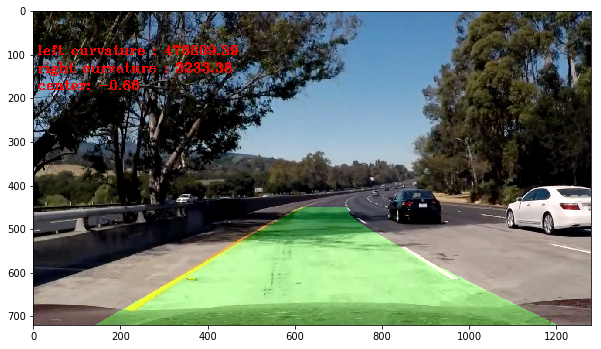

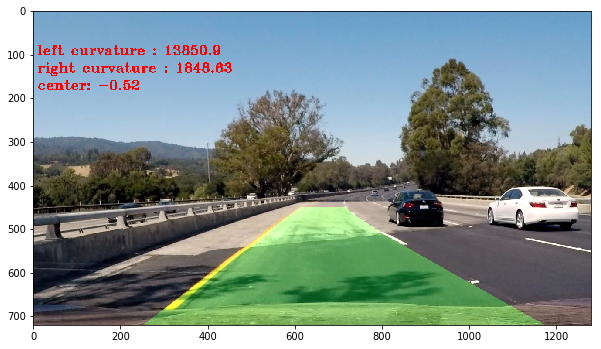

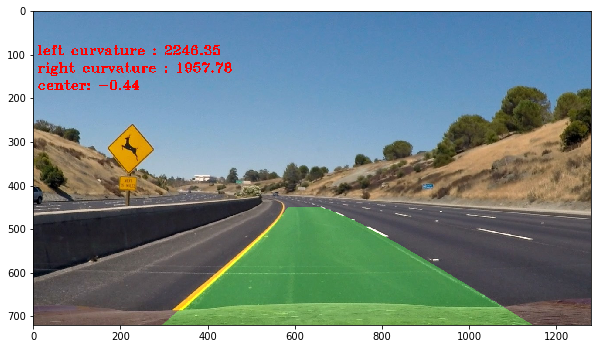

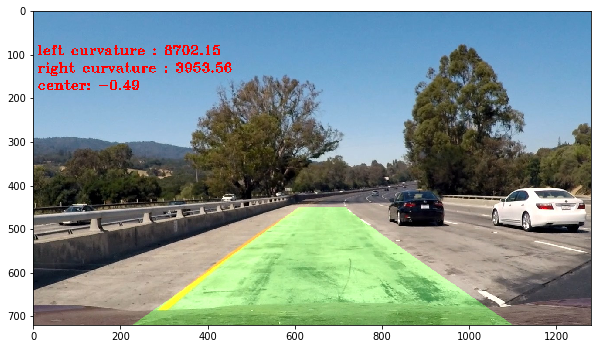

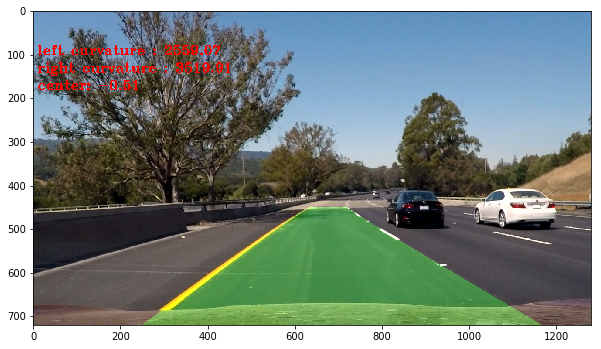

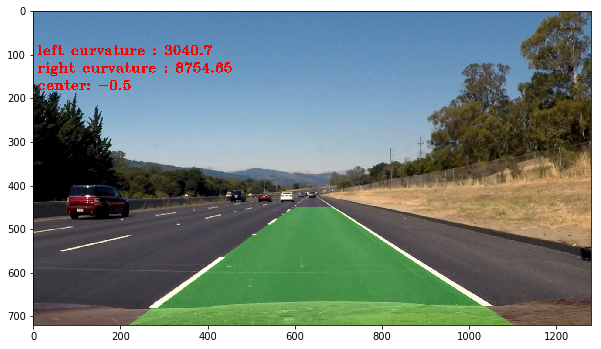

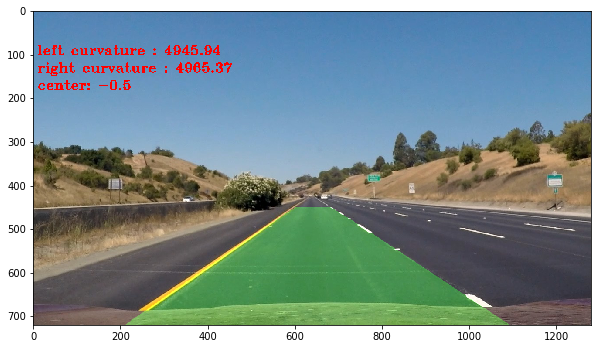

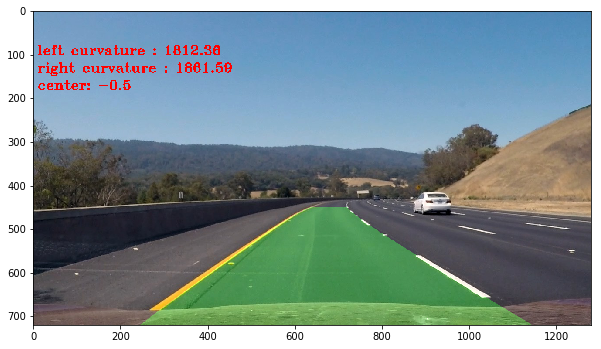

In [15]:
test_images = glob.glob("test_images/*.*") 
undist_dict = joblib.load("undist_dict.pkl")
for i in range(len(test_images)):
    plt.figure(figsize=(10,9))
    plt.imshow(image_lane_pipeline(test_images[i],undist_dict))


## 5. Testing on Project Video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    undist_dict = joblib.load("undist_dict.pkl")
    result = image_lane_pipeline(image,undist_dict,'video')
    
#     plt.imsave("video_{}.jpg".format(image[0][0]),image)
#     plt.figure(figsize=(10,9))
#     plt.imshow(result)
#     plt.title("video_{}.jpg".format(image[0][0]))
    return result

In [18]:
white_output = 'project_video_r.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(41,42)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_r.mp4
[MoviePy] Writing video project_video_r.mp4


100%|█████████▉| 1260/1261 [05:58<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_r.mp4 

CPU times: user 3min 16s, sys: 28.7 s, total: 3min 45s
Wall time: 6min 1s


## 6. Testing on Challenge Video

In [19]:
white_output = 'challenge_video_r.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_r.mp4
[MoviePy] Writing video challenge_video_r.mp4


100%|██████████| 485/485 [02:12<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_r.mp4 

CPU times: user 1min 11s, sys: 11 s, total: 1min 22s
Wall time: 2min 15s
